In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import openmc

import os
import numpy as np

In [4]:
#Initial starting source, uniform in fuel only
bounds = [-0.4, -0.4, -0.4, 0.4, 0.4, 0.4]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)

In [60]:
batches=100
settings = openmc.Settings()
settings.source = openmc.source.Source(space=uniform_dist)
settings.batches = batches
settings.inactive = 25  # keep this at a min of 25, this is the number of power iterations performed, more is always better
settings.particles = 10000  # increase this number to make your results more accurate
settings.temperature = {'tolerance':10000,'multipole':True}
#settings.temperature = {'method':'interpolation','multipole':True}
settings.export_to_xml()

def buildRange(lower, upper, steps):
    out=[]
    stepSize=(upper-lower)/(steps)
    buffer=lower
    while buffer<=upper:
        out.append(buffer)
        buffer+=stepSize
    return out

In [47]:

def getU(T):
    #got to watch out for those Uranium diggers
    #nukeLife
    uo2 = openmc.Material(1,"fuel",temperature=T)
    uo2.add_element('U', 1.0, enrichment=4.0)
    uo2.add_element('O', 2.0)
    uo2.set_density('g/cc', 10.0)
    return uo2
def getZirc():
    zirconium = openmc.Material(2, "zirconium", temperature=temp2)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)
    return zirconium

def getMod(mod, boron,T):
    if(mod=="H2O"):
            #this function creates borated light water, for other moderators you will need to replace
        mod = openmc.model.borated_water(boron_ppm=boron, temperature=T,pressure=15)
    elif(mod=="D2O"):
        pass
    elif(mod=="GRPHT"):
        pass
    return mod




In [57]:
def buildTallies(cell_filter):
    ###################################Tallies#######################
    #tallies over 2 energy groups with 4 eV being thermal bound
    energy_filter = openmc.EnergyFilter([0., 4.0, 20.0e6])
    t = openmc.Tally(1)
    t.filters = [cell_filter, energy_filter]
    # these are the main reaction rates you should need
    t.scores = ['absorption','nu-fission','fission']
    tallies = openmc.Tallies([t])
    tallies.export_to_xml()
    
def parseK(batch):
    #read in the tallies
    sp = openmc.StatePoint('statepoint.'+batch+'.h5')
    # this reads the tally with all reaction rates, not just absorption
    tally = sp.get_tally(scores=['absorption'])
    # this is the final k-effective of the simulation
    os.remove('statepoint.'+batch+'.h5')
    os.remove('summary.h5')
    return sp.k_combined[0]

In [56]:
def buildRectangUni(modSetting, pitch, diameter,boron,modT,fuelT):
    uo2=getU(fuelT)
    mod=getMod(modSetting,boron,modT) #loads the moderator
    mats = openmc.Materials([uo2, mod])
    mats.export_to_xml()
       
    ####################build the surfaces################################
    fuel_or = openmc.ZCylinder(R=diameter/2)
    box = openmc.get_rectangular_prism(width=pitch, height=pitch,boundary_type='reflective')
        
    #################Build the Cells #######################################
    fuel_region = -fuel_or   #beautiful abuse of operator overloading
    mod_region = box & +fuel_or
    # c
    # c Fuel 
    # c
    # c throwback to MCNP
    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = uo2
    fuel.region = fuel_region
    #
    # Moderator 
    #
    moderator = openmc.Cell(4, 'moderator')
    moderator.fill = mod
    moderator.region = mod_region
       
    #I am groot!
    groot = openmc.Universe(cells=(fuel, moderator))
    geom = openmc.Geometry(groot)
    geom.export_to_xml()
    cell_filter = openmc.CellFilter([fuel, moderator])
    # tallies
    buildTallies(cell_filter)

In [ ]:
pitch = buildRange(2,5,10)
boron = [0]
nt = len(pitch)
nb = len(boron)
modT = 900  #fuel temp
fuelT = 600  #mod temp
modSetting="H2O"
diameter=1.0
k = np.zeros([nt,nb])
for m in range(nb):
    for j in range(nt):
        
        #build the problem first
        buildRectangUni(modSetting,pitch[j],diameter,boron[m],modT,fuelT)
        openmc.run()
        k[j,m] = sp.k_combined[0]

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/data/data.py:251: UserWarning: Results are not valid for temperatures above 623.15 K.
  warn("Results are not valid for temperatures above 623.15 K.")
/opt/openmc/gnu-dev/openmc/data/data.py:271: UserWarning: Results are not valid for temperatures above saturation (above the boiling point).
  warn("Results are not valid for temperatures above saturation "
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)



                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

In [51]:
print(k)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


(array([ 1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ]),
 <a list of 9 Text yticklabel objects>)

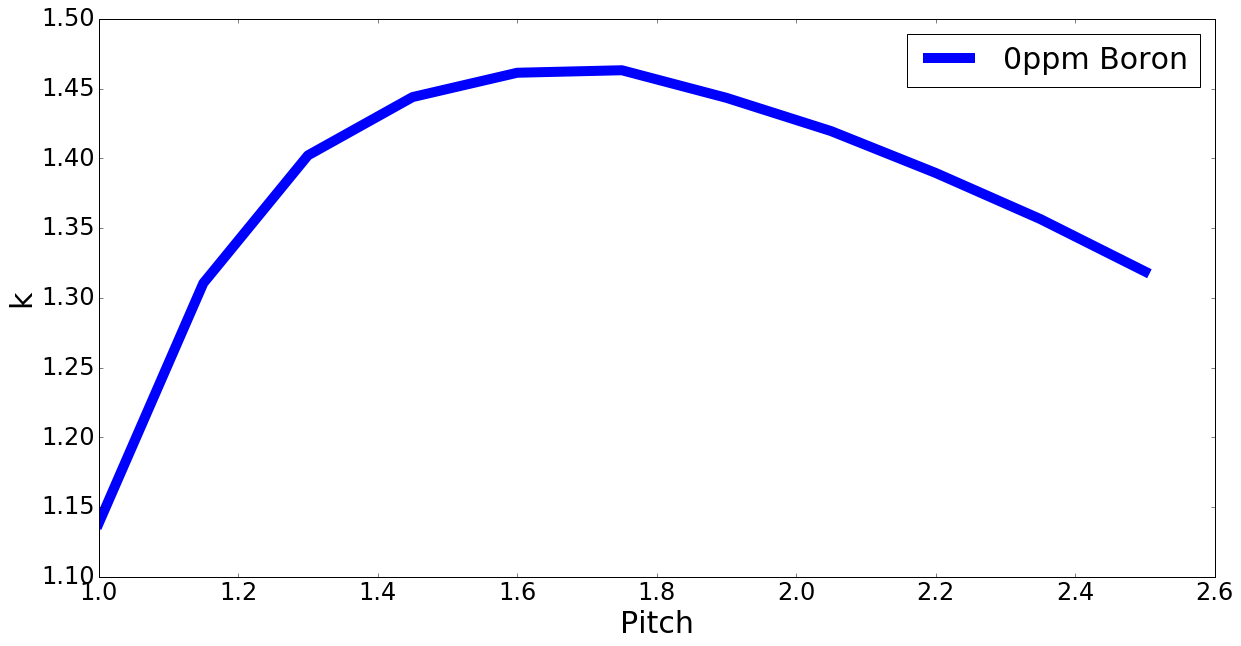

In [25]:
plt.figure(figsize=(20,10))
plt.plot(pitch,k[:,0], linewidth=10)
plt.legend(['0ppm Boron'], fontsize=30)
plt.xlabel('Pitch', fontsize=30)
plt.ylabel('k', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)